In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00


In [ ]:
from torch_geometric.data import Data
import torch

# Schelethon for sysntetic datasets with
def chain_graph_datasets(n):
  chains_dataset = []
  for i in range(0, n-6):
    edge_index = torch.tensor([[j, j+1] for j in range(0,n-6)] +
                     [[j+1, j] for j in range(0,n-5)], dtype=torch.long).T

    x = torch.tensor([[j] for j in range(0,n-5)])

    graph = Data(x=x, edge_index=edge_index)

    chains_dataset.append(graph)

  return chains_dataset

In [ ]:
def circle_graph_datasets(n):
  circles_dataset = []
  for i in range(0, n-6):
    edge_index = torch.tensor([[j, (j+1)%(n-4)] for j in range(0,n-4)] +
                     [[(j+1)%(n-4), j] for j in range(0,n-4)], dtype=torch.long).T

    x = torch.tensor([[j] for j in range(0, n-4)])

    graph = Data(x=x, edge_index=edge_index)

    circles_dataset.append(graph)

  return circles_dataset

chains = chain_graph_datasets(10)
circles = circle_graph_datasets(10)

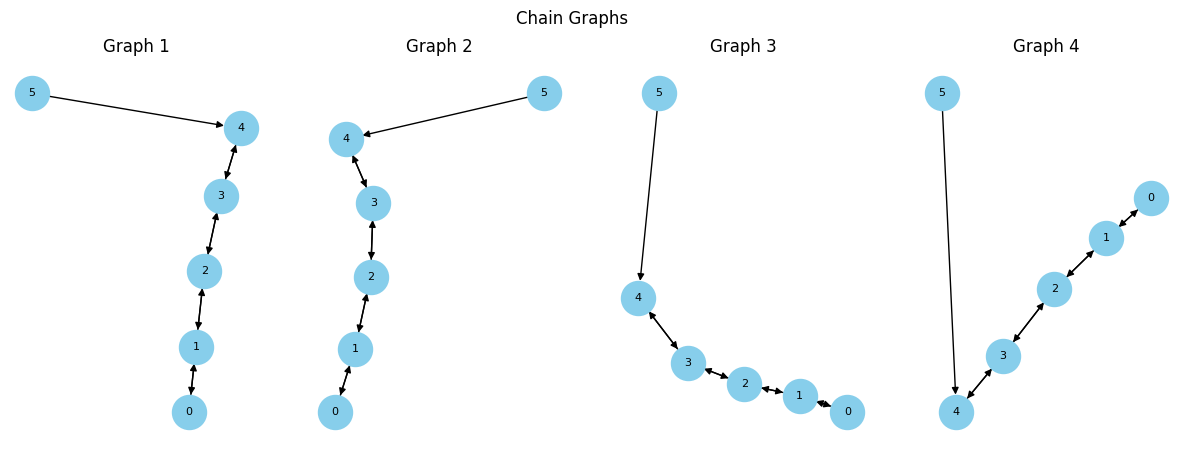

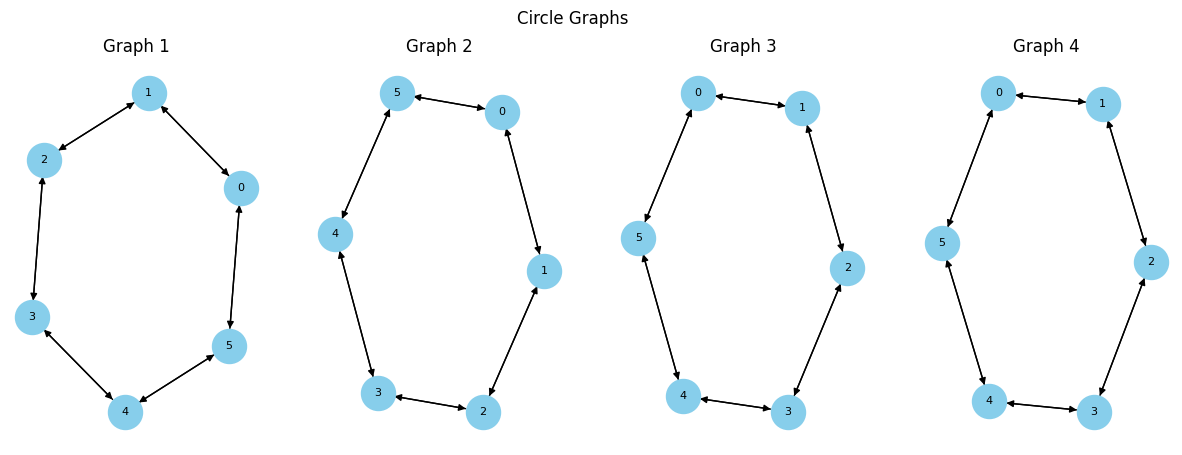

In [ ]:
#@title Plot Datasets

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Function to plot graphs
def plot_graphs(dataset, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)

    for i, graph in enumerate(dataset, start=1):
        plt.subplot(1, len(dataset), i)

        # Convert to NetworkX graph
        nx_graph = to_networkx(graph)

        # Plot the graph using networkx and matplotlib
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_color="skyblue", node_size=600, font_size=8, font_color="black")
        plt.title(f'Graph {i}')

    plt.show()


# Plot chain graphs
plot_graphs(chains, 'Chain Graphs')

# Plot circle graphs
plot_graphs(circles, 'Circle Graphs')

In [ ]:
# Just nice to visualise what is going on in terms of what the tensors look like
# for x and edge_index. Note, we need to transpose edge_index to have it be (2, E)
n=10
x = torch.tensor([[j] for j in range(0, n-5)])

edge_index = torch.tensor([[j, (j+1)%(n-5)] for j in range(0,n-5)] +
                     [[(j+1)%(n-5), j] for j in range(0,n-5)], dtype=torch.long).T
print(x, edge_index)

tensor([[0],
        [1],
        [2],
        [3],
        [4]]) tensor([[0, 1, 2, 3, 4, 1, 2, 3, 4, 0],
        [1, 2, 3, 4, 0, 0, 1, 2, 3, 4]])


In [ ]:
#@title Data Augmentation [Task 3]

from torch_geometric.utils import get_laplacian, to_dense_adj
import torch
from typing import Any
import torch
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
import copy


class AddSpectra(BaseTransform):
    def __call__(self, data: Any) -> Any:
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))

    def forward(self, data: Data) -> Any:
        eigenvalues, eigenvectors = self.get_eigen_decomp(data, "sym")
        data.eigenvectors = eigenvectors[0].T
        data.eigenvalues = eigenvalues
        return  data

    def get_eigen_decomp(self, graph, norm):
        adj = to_dense_adj(graph.edge_index)
        print(adj)
        eigenvalues, eigenvectors = torch.linalg.eigh(adj, UPLO='L')
        print(eigenvalues, eigenvectors)
        return  eigenvalues, eigenvectors

In [ ]:
chains_transformed = [AddSpectra()(chain) for chain in chains]
circles_transformed = [AddSpectra()(circle) for circle in circles]

tensor([[[0., 1., 0., 0., 0., 0.],
         [1., 0., 1., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.]]])
tensor([[-1.8019, -1.2470, -0.4450,  0.4450,  1.2470,  1.8019]]) tensor([[[ 0.2319, -0.4179, -0.5211,  0.5211, -0.4179,  0.2319],
         [-0.4179,  0.5211,  0.2319,  0.2319, -0.5211,  0.4179],
         [ 0.5211, -0.2319,  0.4179, -0.4179, -0.2319,  0.5211],
         [-0.5211, -0.2319, -0.4179, -0.4179,  0.2319,  0.5211],
         [ 0.4179,  0.5211, -0.2319,  0.2319,  0.5211,  0.4179],
         [-0.2319, -0.4179,  0.5211,  0.5211,  0.4179,  0.2319]]])
tensor([[[0., 1., 0., 0., 0., 0.],
         [1., 0., 1., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.]]])
tensor([[-1.8019, -1.2470, -0.4450,  0.4450,  1.2470,  1.8019]]) tensor([[[ 0.2319, -0.4179, -0.5211,  0.5211, -0.4179,

In [ ]:
#@title Ploting augmented data

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def plot_augmented_graphs(dataset, title, eigenvalue_nr):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title + str(eigenvalue_nr))

    for i, graph in enumerate(dataset, start=1):
        plt.subplot(1, len(dataset), i)

        # Convert to NetworkX graph
        nx_graph = to_networkx(graph)

        # Get eigenvector for coloring nodes

        node_colors = graph.eigenvectors[eigenvalue_nr].tolist()


        # Plot the graph using networkx and matplotlib
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_color=node_colors,
                cmap=plt.cm.Blues, node_size=600, font_size=8, font_color="black")

        plt.title(f'Graph {i}')

    plt.show()


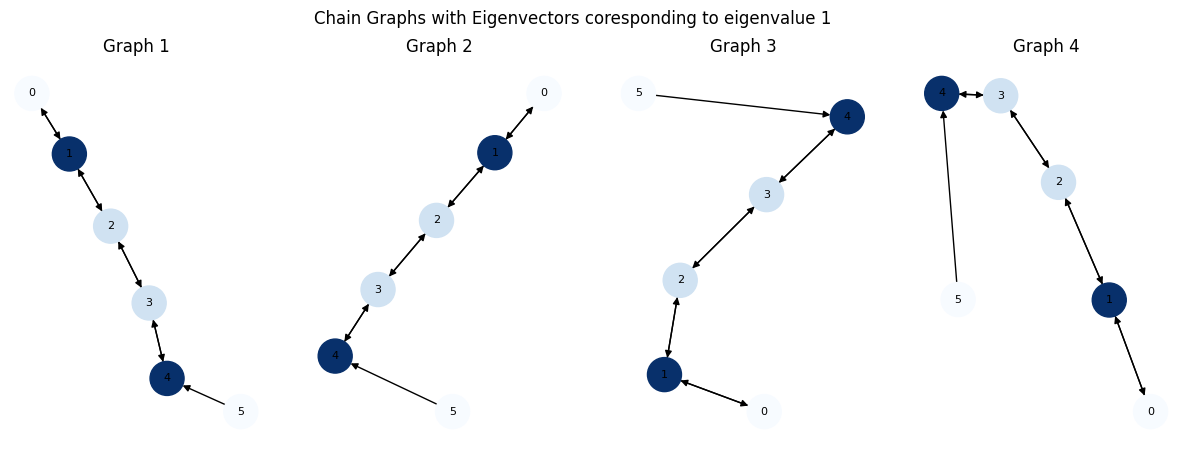

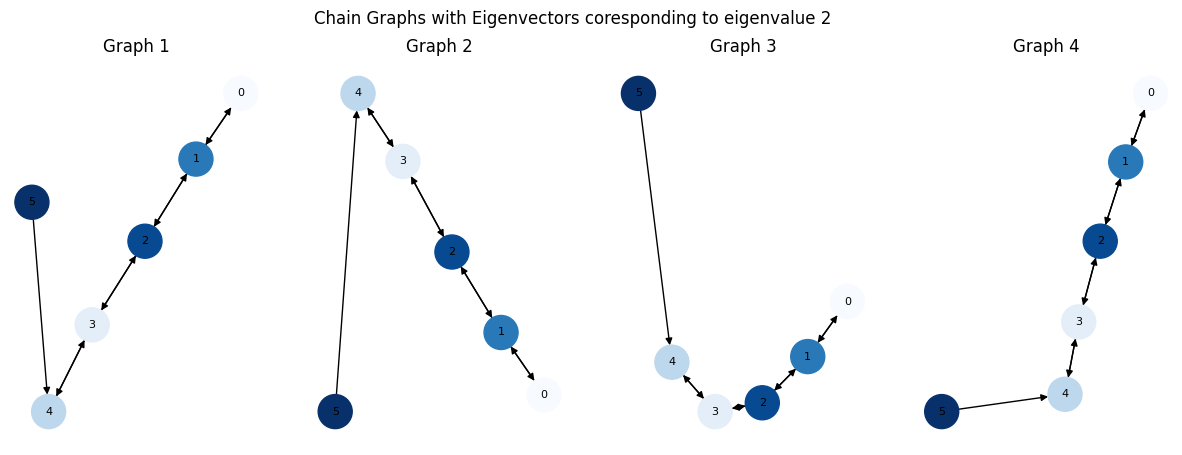

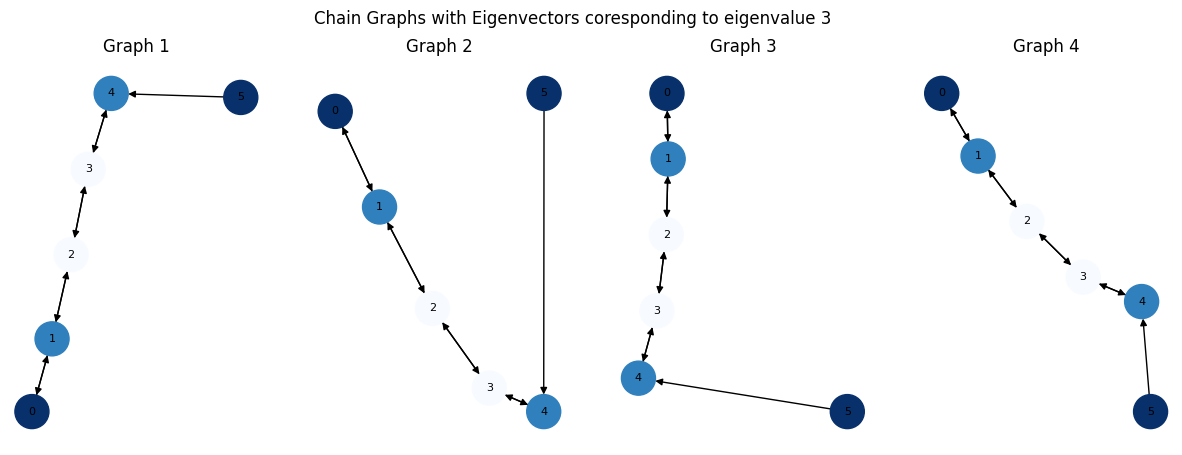

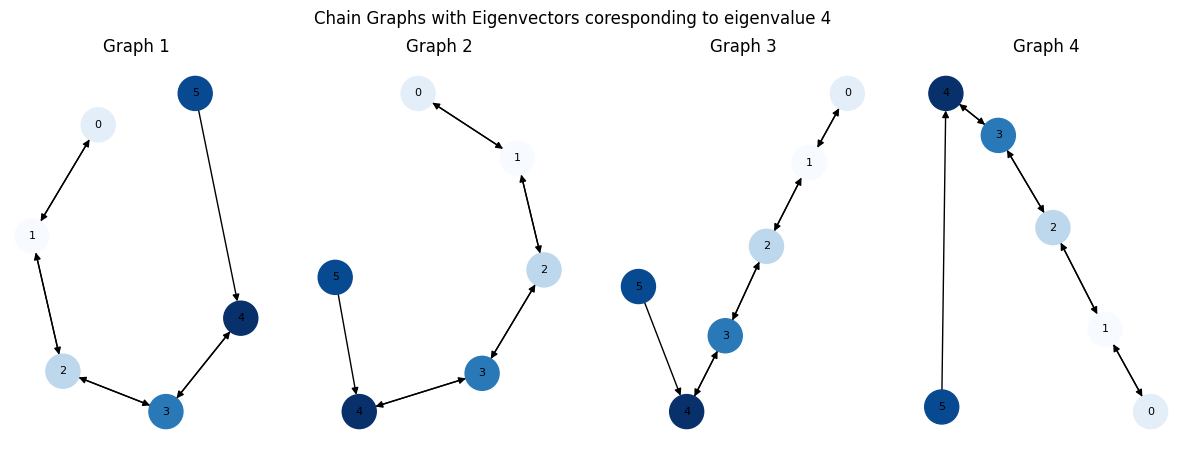

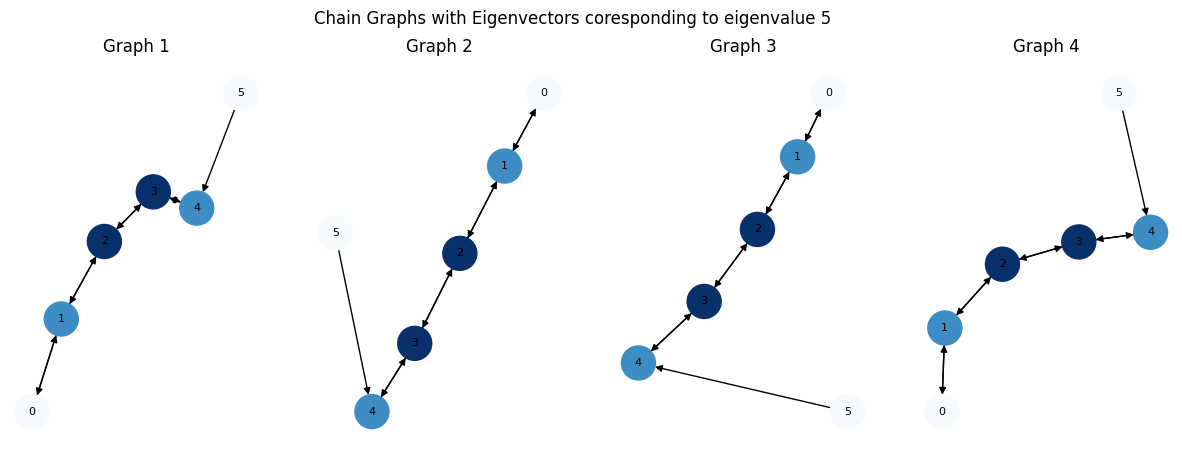

In [ ]:
#@title Plot chain graphs with eigenvectors
plot_augmented_graphs(chains_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 1)
plot_augmented_graphs(chains_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 2)
plot_augmented_graphs(chains_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 3)
plot_augmented_graphs(chains_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 4)
plot_augmented_graphs(chains_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 5)

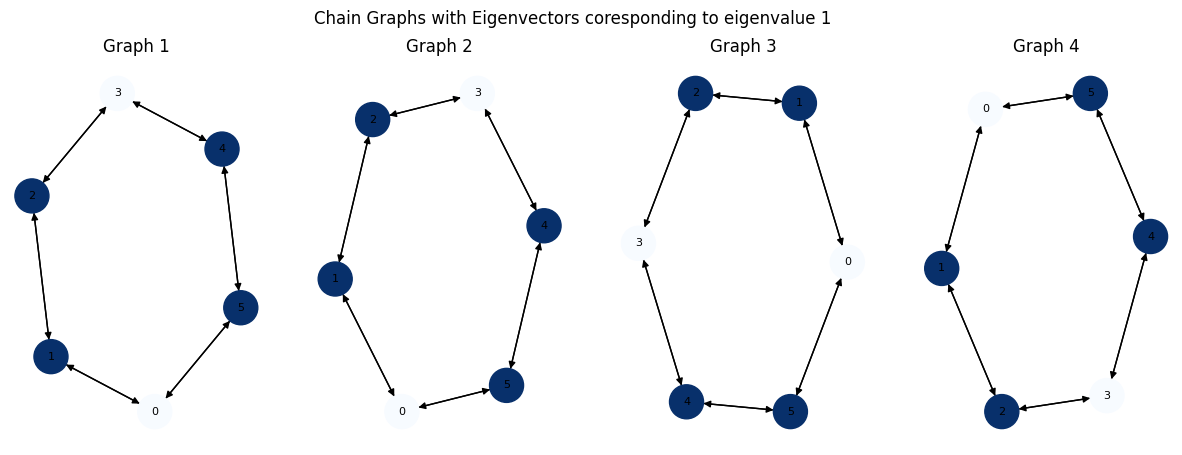

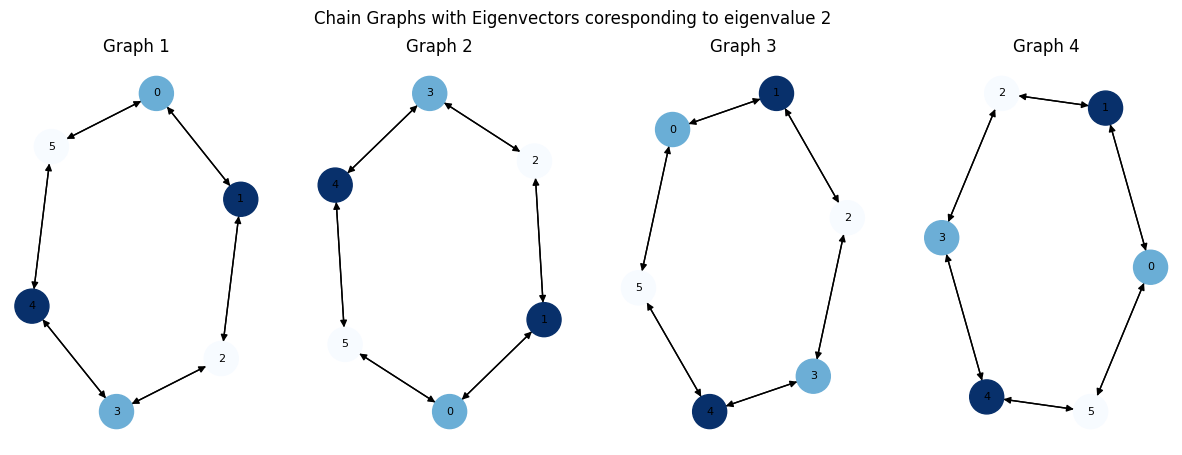

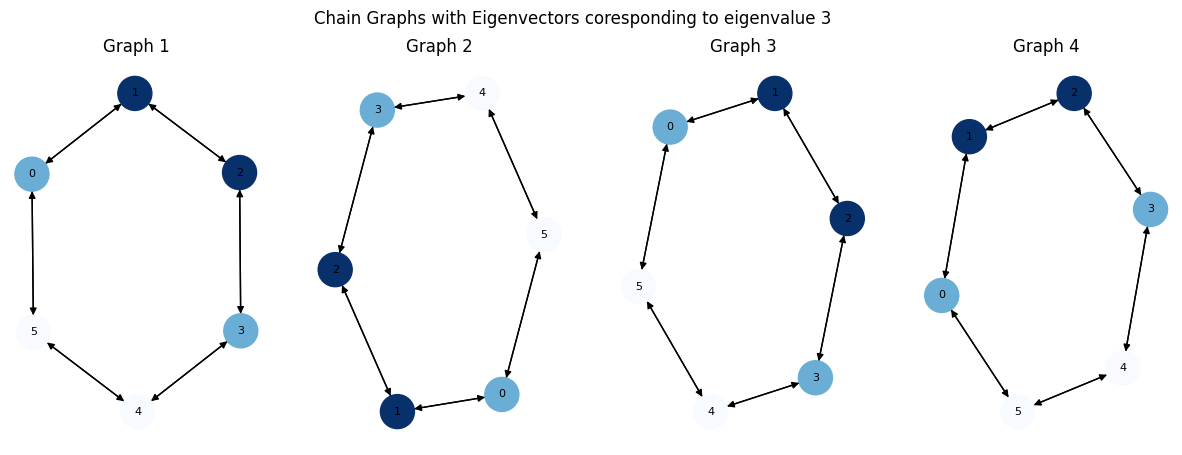

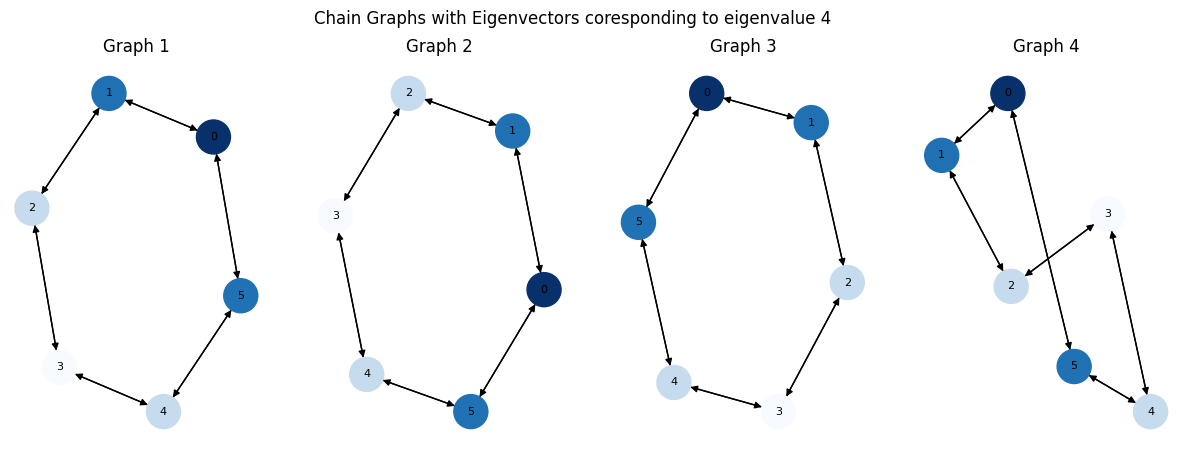

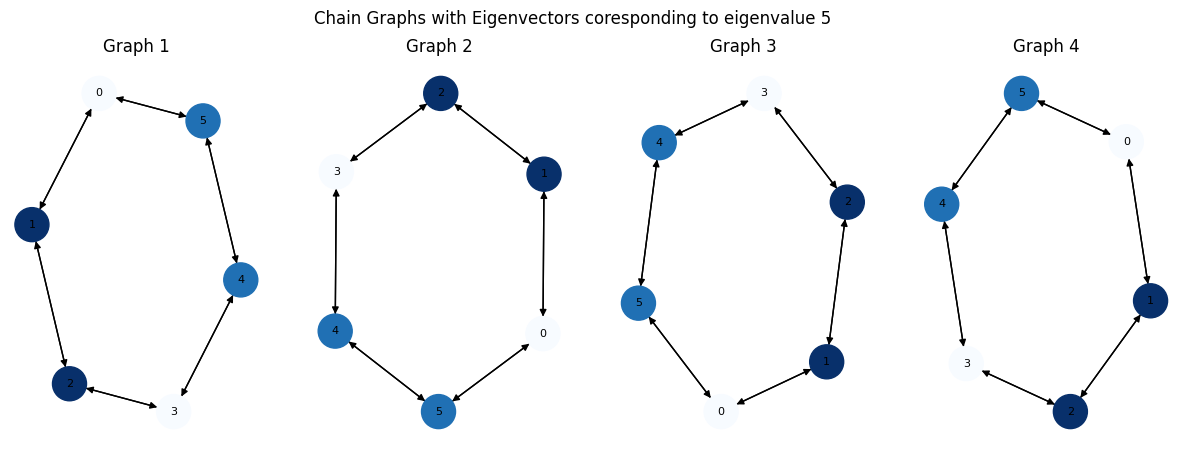

In [ ]:
#@title Plot cycle graphs with eigenvectors
plot_augmented_graphs(circles_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 1)
plot_augmented_graphs(circles_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 2)
plot_augmented_graphs(circles_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 3)
plot_augmented_graphs(circles_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 4)
plot_augmented_graphs(circles_transformed, 'Chain Graphs with Eigenvectors coresponding to eigenvalue ', 5)

In [ ]:
#@title Load Dataset
from torch_geometric.datasets import MNISTSuperpixels
import numpy as np
train_dataset = MNISTSuperpixels(root='dataset/MNIST/', train=True)
test_dataset = MNISTSuperpixels(root='dataset/MNIST/', train=False)

Extracting dataset/MNIST/raw/MNISTSuperpixels.zip
Processing...
/usr/local/lib/python3.10/dist-packages/torch_geometric/datasets/mnist_superpixels.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

In [ ]:
#@title Implement GCN
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F

class GCNModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 128)
        self.pool = global_mean_pool
        self.lin_pred = Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.pool(x, batch)
        x = self.lin_pred(x)
        return x

In [ ]:
#@title Implement ChebNet
import torch
from torch_geometric.nn import ChebConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F

class ChebNetModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ChebNetModel, self).__init__()
        self.conv1 = ChebConv(num_features, 64, K=3)
        self.conv2 = ChebConv(64, 128, K=3)
        self.conv3 = ChebConv(128, 128, K=3)
        self.pool = global_mean_pool
        self.lin_pred = Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.pool(x, batch)
        x = self.lin_pred(x)

        return x

In [ ]:
#@title Training and Testing Loop
def train(model,train_loader, optimizer, epoch=50):
    model.train()
    for epoch in range(epoch):
        losses = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            losses += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {losses/len(train_loader)}')

def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.to(device))
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
#@title Training setup
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

# Initialize models
num_features = train_dataset.num_features
num_classes = 10  # MNIST has 10 classes

gcn_model = GCNModel(num_features, num_classes).to(device)
chebnet_model = ChebNetModel(num_features, num_classes).to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
chebnet_optimizer = torch.optim.Adam(chebnet_model.parameters(), lr=0.01)

In [ ]:
# Training loop for GCN
train(gcn_model,train_loader, gcn_optimizer)

# Evaluate GCN
gcn_accuracy = test(gcn_model, test_loader)
print(f'GCN Accuracy: {gcn_accuracy}')

Epoch 0, Loss: 2.297998611132304
Epoch 10, Loss: 1.8957834045092266
Epoch 20, Loss: 1.8347162087758382
Epoch 30, Loss: 1.7976438045501708
Epoch 40, Loss: 1.7523923198382059
GCN Accuracy: 0.3747


In [ ]:
# Training loop for Chebnet
train(chebnet_model,train_loader, chebnet_optimizer)

# Evaluate ChebNet
chebnet_accuracy = test(chebnet_model, test_loader)
print(f'ChebNet Accuracy: {chebnet_accuracy}')

Epoch 0, Loss: 2.2992013772328694
Epoch 10, Loss: 2.002899233500163
Epoch 20, Loss: 2.0153640707333884
Epoch 30, Loss: 1.9948365370432535
Epoch 40, Loss: 1.9942751248677573
ChebNet Accuracy: 0.2516


With regards to the ChebNet model we may find it interesting to see how as we vary the hyperparameter K, we get different results.  


K=1:

Epoch 0, Loss: 2.2992013772328694
Epoch 10, Loss: 2.002899233500163
Epoch 20, Loss: 2.0153640707333884
Epoch 30, Loss: 1.9948365370432535
Epoch 40, Loss: 1.9942751248677573

ChebNet Accuracy: 0.2516

K=3:

Epoch 0, Loss: 2.214774505297343
Epoch 10, Loss: 1.4400860905647277
Epoch 20, Loss: 1.1690396149953206
Epoch 30, Loss: 1.0306532820065817
Epoch 40, Loss: 0.9571028192838033

ChebNet Accuracy: 0.6938


Clearly, the results are significantly better with K=3. but obviously comes at the cost of a higher computational demand, but significantly better results